# Preamble

Here we import all the necessary python packages for our calculations. These include:
- `numpy` for fast calculations
- `healpy` for creating/loading/manipulating pixelised maps of the fields we wish to cross-correlate
- `matplotlib.pyplot` for plotting our results
- `pymaster` for computing angular power spectra
- `sacc` for storing our results in a convenient format

In [2]:



import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import pymaster as nmt
import sacc
from matplotlib.colors import SymLogNorm

# Load data

Let's first load the masks corresponding to the different surveys. These masks reflect the survey geometry, and serve to downweight pixels in which measurements of the field are expected to be less reliable -- e.g. the observed galaxy density is likely to be less reliable in regions near bright stars, as the light from these stars obscures the light from more distant objects.

In [3]:
# Directory in which the maps are stored
path_maps = 'SkyMaps/GCxCIB/maps/'
# Load the HSC mask
mask_hsc = hp.read_map(path_maps + 'hsc_mask_nside1024.fits')
# Load the CIB mask
mask_cib = hp.read_map(path_maps + 'cib_mask_nside1024.fits')

Now we load the maps for the fields we want to cross-correlate. Here we are loading maps of the galaxy density contrast, $\delta_g$, for 4 galaxy samples selected from HSC DR3. These samples were selected to lie in the following redshift ranges:
- $0.3 \leq z < 0.6$
- $0.6 \leq z < 0.9$
- $0.9 \leq z < 1.2$
- $1.2 \leq z < 1.5$

In [4]:
# Load all 4 HSC maps and store in a list
dg_maps = [hp.read_map(path_maps + f'hsc_zbin{i}_nside1024.fits') for i in range(4)]

The final ingredient is the map of the CIB intensity, measured in a band whose effective wavelength is 857 ${\mu}{\rm m}$.

In [5]:
# Load the CIB map
cib_map = hp.read_map(path_maps + 'cib_857micron_signal_nside1024.fits')

We will also make a note of some of the key properties of the maps: namely, the $N_{\rm side}$ parameter defining the resolution of the maps, and the corresponding maximum multipole we can probe with these maps ($\ell_{\rm max} = 3 N_{\rm side} - 1$).

In [6]:
# Already know the maps have Nside = 1024
nside = 1024
# ... but can check anyway (will return error if not true)
assert nside == hp.npix2nside(len(mask_hsc))

# Computing angular power spectra

We are interested in how fluctuations in the galaxy density contrast are related to fluctuations in the intensity of the CIB. This can be quantified using angular power spectra (denoted by $C_\ell$).

## Projected fields

Let $u(\hat{\bf n})$ be a cosmological field projected on a sphere, and assume it is the radial projection of a 3D field $U$, i.e. $$u(\hat{\bf n}) = \int d\chi q_u(\chi)U(\chi \hat{\bf n}, z) \tag{1}\,.$$Here $\chi$ is the comoving distance, $q_u(\chi)$ is the radial kernel associated with $u$, and $z$ is the redshift corresponding to $\chi$.

The angular power spectrum of two such quantities, $u$ and $v$, is defined as the covariance between their harmonic-space coefficients, and is related to the power spectrum of the corresponding 3D quantities, $P_{UV}(k,z)$ via $$C_\ell^{uv} = \int \frac{d\chi}{\chi^2} q_u(\chi)q_v(\chi)P_{UV}\left( k = \frac{\ell + 1/2}{\chi}, z \right)\,.$$ (The above equation assumes the so-called Limber approximation, which is appropriate for the cross-correlations we will consider.)

Note that one can also measure the 'auto'-power spectrum by cross-correlating a field $u$ with itself. In this case, $C_\ell^{uu}$ is the *variance* of the harmonic-space coefficients.

## Measuring $C_\ell$ from the data

`NaMaster` is capable of estimating angular power spectra given a set of maps and corresponding masks. The first step is to create `NmtField` objects from these pieces of information, with one `NmtField` per map.

In [7]:
# NmtField for the HSC overdensity maps
f_dg = [nmt.NmtField(mask_hsc, [m]) for m in dg_maps]
# NmtField for the CIB map
f_cib = nmt.NmtField(mask_cib, [cib_map])

Next we need to construct `NmtWorkspace`s for the computation of mode-coupling matrices (denoted by $M_{\ell\ell^{\prime}}$), which describe the coupling of different angular multipoles $\ell$ induced by the presence of sky masks.

In [8]:
# Define bandpowers (we will use linearly spaced bins 40 multipoles wide)
b = nmt.NmtBin.from_nside_linear(nside, 40)
# Create NmtWorkspace
wsp_HSC_CIB = nmt.NmtWorkspace.from_fields(f_dg[0], f_cib, b)
wsp_HSC_HSC = nmt.NmtWorkspace.from_fields(f_dg[0], f_dg[1], b)
wsp_CIB_CIB = nmt.NmtWorkspace.from_fields(f_cib, f_cib, b)

In [38]:
nmt.bins.get_ell_max(b)

AttributeError: module 'pymaster.bins' has no attribute 'get_ell_max'

n_ell_large: 3041


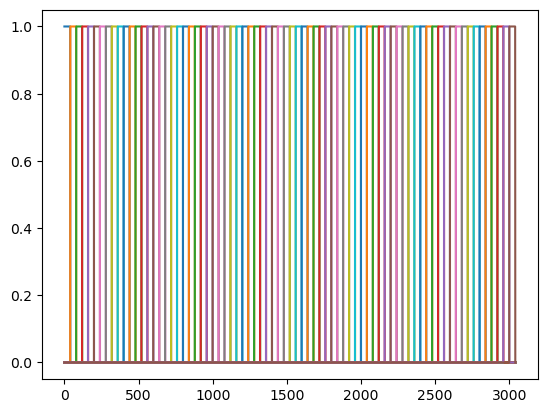

In [33]:
# Assuimg top hat window functions for the bandpowers - NaMaster only supports top hat windows, so valid

n_ell_eff = b.get_effective_ells() 
n_ell_large = b.get_ell_max(b.get_n_bands() - 1)  # Get the maximum ell for the last bandpower

ells_large = np.arange(n_ell_large)

print("n_ell_large:", n_ell_large)  
window_single = np.zeros([len(n_ell_eff), n_ell_large])
for i in range(b.get_n_bands()):
    window_single[i, i* 40: (i+1) * 40] = 1.0

plt.figure()
for w in window_single:
    plt.plot(ells_large, w)



We can now compute our angular power spectra. This is done by first computing a naive estimate directly from the masked fields (the so-called 'coupled $C_\ell$'), then using the `NmtWorkspace` and its stored mode-coupling matrix to 'decouple' this estimate and convolve it with the bandpower window functions.

In [23]:
cells_coupled = []
cells = []
for i in range(len(f_dg)):
    # Coupled estimate for the current HSC map cross-correlated with CIB
    cl_coupled = nmt.compute_coupled_cell(f_dg[i], f_cib)
    cells_coupled.append(cl_coupled)
    # Decoupled estimate
    cl = wsp_HSC_CIB.decouple_cell(cl_coupled)
    cells.append(cl)


I will now compute the angular power spectra for the auto-correlations

In [24]:
auto_cells_couples = []
auto_cells = []
for i in range(len(f_dg)):
    # Coupled estimate for the auto-correlation of the current HSC map
    cl_auto_coupled = nmt.compute_coupled_cell(f_dg[i], f_dg[i])
    auto_cells_couples.append(cl_auto_coupled)
    # Decoupled estimate
    cl_auto = wsp_HSC_HSC.decouple_cell(cl_auto_coupled)
    auto_cells.append(cl_auto)



## Covariances

We need `NmtCovarianceWorkspace`s in order to compute the covariances between bandpowers (and thus get the uncertainties on our measurements).

In [9]:
covwsp = nmt.NmtCovarianceWorkspace()
#covwsp.compute_coupling_coefficients(f_dg[0], f_cib)

Given a pair of ${C_\ell}{\rm s}$ computed for two pairs of fields, $C_\ell^{i_1i_2}$ and $C_\ell^{j_1j_2}$, `NaMaster` can compute an estimation of the covariance matrix ${\rm Cov}(C_\ell^{i_1i_2}, C_\ell^{j_1j_2})$ given the following ingredients:
- `NmtField`s corresponding to the fields $i_1$, $i_2$, $j_1$ and $j_2$
- a reasonable guess of what the true ${C_\ell \rm s}$ should be
- `NmtWorkspace`s correpsonding to $C_\ell^{i_1i_2}$ and $C_\ell^{j_1j_2}$
- `NmtCovarianceWorkspace` defined from the fields $i_1$, $i_2$, $j_1$ and $j_2$.

This function below is a wrapper gathers these ingredients, estiamtes the true ${C_\ell \rm s}$, and then employs `NaMaster`'s covariance estimator to compute and return the covariance matrix.

In [10]:
def compute_covariance(cw, wi, f_i1, f_i2, wj=None, f_j1=None, f_j2=None, f_sky=None):
	'''
	Computes the Gaussian covariance for a pair of angular power spectra,
	given the fields used to compute said spectra. 

	Parameters
	----------
	cw: pymaster.NmtCovarianceWorkspace
		Covariance workspace defined with all masks involved.

	wi: pymaster.NmtWorkspace
		NaMaster workspace defined with the mask involved in the first power spectrum.
	
	f_i1, f_i2: pymaster.NmtField, pymaster.NmtField
		Fields contributing to the first power spectrum.
	
	wj: pymaster.NmtWorkspace
		NaMaster workspace defined with the mask involved in the second power spectrum.
		If None, will be set to wi.
	
	
	f_j1, f_j2: pymaster.NmtField, pymaster.NmtField
		Fields contributing to the second power spectrum. If None, will be set
		to f_i1 and f_i2.
	
	f_sky: float
		Estimate of the observed sky fraction (assumed the same for all fields).
		If None, will calculate using the mask.
	
	Returns
	-------
	covar: numpy.ndarray
		Covariance matrix for the pair of angular power spectra.
	'''
	#see if additional fields have been provided for the second power spectrum
	if f_j1 is None:
		f_j1 = f_i1
	if f_j2 is None:
		f_j2 = f_i2
	#see if a separate workspace has been provided
	if wj is None:
		wj = wi
	
	#if no sky fraction estimate is provided, compute from mask
	if f_sky is None:
		f_sky_i1j1 = np.mean(f_i1.get_mask() * f_j1.get_mask())
		f_sky_i1j2 = np.mean(f_i1.get_mask() * f_j2.get_mask())
		f_sky_i2j1 = np.mean(f_i2.get_mask() * f_j1.get_mask())
		f_sky_i2j2 = np.mean(f_i2.get_mask() * f_j2.get_mask())

	
	#compute coupled c_ells for each possible combination of i and j
	cl_coupled_i1j1 = nmt.compute_coupled_cell(f_i1, f_j1)
	cl_coupled_i1j2 = nmt.compute_coupled_cell(f_i1, f_j2)
	cl_coupled_i2j1 = nmt.compute_coupled_cell(f_i2, f_j1)
	cl_coupled_i2j2 = nmt.compute_coupled_cell(f_i2, f_j2)
	#use these along with the mask to get a guess of the true C_ell
	cl_guess_i1j1 = cl_coupled_i1j1 / f_sky_i1j1
	cl_guess_i1j2 = cl_coupled_i1j2 / f_sky_i1j2
	cl_guess_i2j1 = cl_coupled_i2j1 / f_sky_i2j1
	cl_guess_i2j2 = cl_coupled_i2j2 / f_sky_i2j2


	covar = nmt.gaussian_covariance(cw, 
									0, 0, 0, 0,			#spin of each field
									[cl_guess_i1j1[0]],	
									[cl_guess_i1j2[0]],
									[cl_guess_i2j1[0]],
									[cl_guess_i2j2[0]],
									wi,
									wj)

	return covar

In [11]:
def covariance_to_correlation(cov):
    '''
    Converts a covariance matrix to a correlation matrix.
    
    Parameters
    ----------
    cov: numpy.ndarray
        Covariance matrix to convert.
    
    Returns
    -------
    corr: numpy.ndarray
        Correlation matrix corresponding to the input covariance matrix.
    '''
    v = np.sqrt(np.diag(cov))
    outer_v = np.outer(v, v)
    corr = cov / outer_v
    corr[cov  == 0] = 0  # Avoid division by zero
    return corr

In [12]:
maps = [f_dg[0], f_dg[1], f_dg[2], f_dg[3], f_cib]  # List of maps to compute covariance for

In [40]:
# Computation of covariance matrix algorithm 

block_matrix_rows = []


for i in range(len(maps)):
    current_row = []
    for j in range(len(maps)):
        if i == j:
            if i < 4:
                # Auto-correlation for HSC maps
                current_row.append(compute_covariance(covwsp, wsp_HSC_HSC, maps[i], maps[j]))
            if i == 4:
                pass
                # Auto-correlation for CIB map
                current_row.append(compute_covariance(covwsp, wsp_CIB_CIB, maps[i], maps[j]))
        else:
            # Cross-correlation
            if i == 4:
                # CIB map cross-correlated with HSC maps
                pass
                current_row.append(compute_covariance(covwsp, wsp_HSC_CIB, maps[i], maps[j]))
            if j == 4:
                # HSC maps cross-correlated with CIB map
                pass
                current_row.append(compute_covariance(covwsp, wsp_HSC_CIB, maps[j], maps[i]))
            if i < 4 and j < 4:
                # HSC maps cross-correlated with each other
                current_row.append(compute_covariance(covwsp, wsp_HSC_HSC, maps[i], maps[j]))
        
    block_matrix_rows.append(current_row)
    
    
        
flattened_covariance = np.block(block_matrix_rows)  # Flatten the covariance matrix to a 2D array

#print("Shape of flattened covariance matrix:", flattened_covariance.shape)

# Correlation matrix

correlation_matrix = covariance_to_correlation(flattened_covariance) - np.eye(flattened_covariance.shape[0])  # Remove the diagonal to focus on correlations

plt.figure(figsize=(40, 32))
plt.matshow(correlation_matrix, cmap='viridis', norm=SymLogNorm(linthresh=1e-3))




# Set the x and y ticks to match the bin names
bin_names = ['HSC zbin 0', 'HSC zbin 1', 'HSC zbin 2', 'HSC zbin 3']
n_ell_band = b.get_n_bands()

tick_positions = np.arange(len(bin_names)) * n_ell_band + n_ell_band // 2
plt.xticks(ticks=tick_positions, labels=bin_names, rotation=45)
plt.yticks(ticks=tick_positions, labels=bin_names)

# add grid lines for better readability
grid_positions = np.arange(len(bin_names) + 1) * n_ell_band - 0.5
plt.grid(which='both',color = 'white', linestyle='-', linewidth=0.5, alpha=0.5)
plt.gca().set_xticks(grid_positions, minor=True)
plt.gca().set_yticks(grid_positions, minor=True)
plt.gca().tick_params(which='minor', length=0)
plt.grid(which='major', visible=False)

plt.colorbar(label='Correlation Coefficient')
plt.title('Correlation Matrix of Angular Power Spectra')

print (grid_positions)

AttributeError: 'NoneType' object has no attribute 'lmax'

Here we are mostly interested in the errors on our ${C_\ell}{\rm s}$, which can be obtained in two steps:
- compute ${\rm Cov}(C_\ell^{\delta_i \times {\rm CIB}}, C_\ell^{\delta_i \times {\rm CIB}})$ where $\delta_i$ is the density contrast map for the $i$th redshift bin
- take the square root of the diagonal of the covariance matrix: $\sigma_\ell = \sqrt{{\rm diag}({\rm Cov})}$

In [39]:
compute_covariance(covwsp, wsp_HSC_CIB, f_dg[0], f_cib)

AttributeError: 'NoneType' object has no attribute 'lmax'

In [34]:
figure = plt.figure(figsize=(10, 8))

err_cells = []
for i in range(len(cells)-1):
    cov = compute_covariance(
        covwsp,
        wsp_HSC_HSC,
        f_dg[i],
        f_dg[i],
    
    )
    
    correlation_matrix = covariance_to_correlation(cov)
    plt.matshow(correlation_matrix, cmap='viridis', norm=SymLogNorm(linthresh=1e-3))
    plt.colorbar(label='Correlation Coefficient')
    
    err = np.sqrt(np.diag(cov))
    err_cells.append(err)

AttributeError: 'NoneType' object has no attribute 'lmax'

<Figure size 1000x800 with 0 Axes>

In [ ]:
cov = compute_covariance(covwsp, wsp_HSC_CIB, f_dg[0], f_cib)
corr = covariance_to_correlation(cov)

plt.figure(figsize=(10, 8))
plt.matshow(corr, cmap='viridis')

NameError: name 'err_cells' is not defined

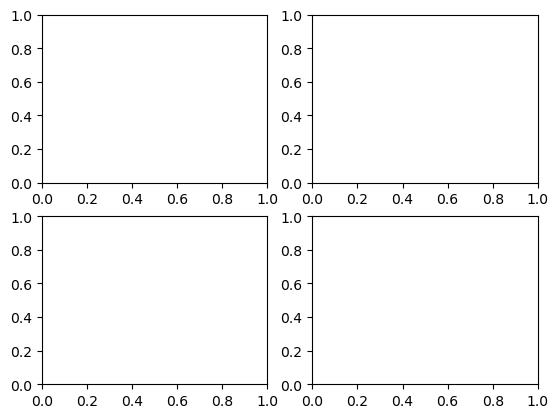

In [29]:
f, ax = plt.subplots(2, 2)
ells = b.get_effective_ells()

for i in range(len(cells)):
    nrow = i // 2
    ncol = i % 2
    ax[nrow,ncol].errorbar(ells, cells[i][0], yerr=err_cells[i], c=f'C{i}', ecolor=f'C{i}', linestyle='none', marker='o')
    ax[nrow,ncol].errorbar(ells, -cells[i][0], yerr=err_cells[i], mec=f'C{i}', mfc='none', ecolor=f'C{i}', linestyle='none', marker='o')

    ax[nrow,ncol].set_xscale('log')
    ax[nrow,ncol].set_yscale('log')

In [ ]:
import h5py as h5

nzs = h5.File('hsc_nzs.hdf5', 'r')

plt.figure(figsize=(10, 8))
for i in range(4):
    plt.plot(nzs['z'][:], nzs[f'nz_{i}'][:], label=f'HSC zbin {i}')
plt.xlabel('Redshift')
plt.ylabel('Redshift Distribution')
plt.legend()
plt.title('HSC Redshift Distributions')

In [ ]:
s = sacc.Sacc()
plt.figure(figsize=(10, 8))
# Temporary z distribution/kernel

z_bins = [(0.3, 0.6),(0.6, 0.9),(0.9, 1.2),(1.2, 1.5)]


for i, (z_min, z_max) in enumerate(z_bins):
    z = nzs['z'][:]
    #plt.plot(z, nzs[f'nz_{i}'][:], label=f'HSC zbin {i}')

    s.add_tracer(
        'NZ', f'hsc_zbin{i}',
        quantity='galaxy_density',
        spin=0,
        z=z,
        nz=nzs[f'nz_{i}'][:],  # Use the dataset from the HDF5 file
    )


s.add_tracer('Misc', 'cib_857micron',
             quantity='intensity',
             spin=0,
             )



In [17]:
# compute all angular power spectra

# HSC auto-correlation and cross-correlation 
cl_g0g0 = nmt.compute_full_master(f_dg[0], f_dg[0], b)
cl_g0g1 = nmt.compute_full_master(f_dg[0], f_dg[1], b)
cl_g0g2 = nmt.compute_full_master(f_dg[0], f_dg[2], b)
cl_g0g3 = nmt.compute_full_master(f_dg[0], f_dg[3], b)

cl_g1g1 = nmt.compute_full_master(f_dg[1], f_dg[1], b)
cl_g1g2 = nmt.compute_full_master(f_dg[1], f_dg[2], b)
cl_g1g3 = nmt.compute_full_master(f_dg[1], f_dg[3], b)

cl_g2g2 = nmt.compute_full_master(f_dg[2], f_dg[2], b)
cl_g2g3 = nmt.compute_full_master(f_dg[2], f_dg[3], b)

cl_g3g3 = nmt.compute_full_master(f_dg[3], f_dg[3], b)

# CIB auto-correlation
cl_cib_cib = nmt.compute_full_master(f_cib, f_cib, b)

# HSC-CIB cross-correlation
cl_g0cib = nmt.compute_full_master(f_dg[0], f_cib, b)
cl_g1cib = nmt.compute_full_master(f_dg[1], f_cib, b)
cl_g2cib = nmt.compute_full_master(f_dg[2], f_cib, b)
cl_g3cib = nmt.compute_full_master(f_dg[3], f_cib, b)




In [20]:
cl_dict = {
    'g0g0': cl_g0g0,
    'g0g1': cl_g0g1,
    'g0g2': cl_g0g2,
    'g0g3': cl_g0g3,
    'g1g1': cl_g1g1,
    'g1g2': cl_g1g2,
    'g1g3': cl_g1g3,
    'g2g2': cl_g2g2,
    'g2g3': cl_g2g3,
    'g3g3': cl_g3g3,
    'cib_cib': cl_cib_cib,
    'g0cib': cl_g0cib,
    'g1cib': cl_g1cib,
    'g2cib': cl_g2cib,
    'g3cib': cl_g3cib,
}

In [28]:
plt.plot(ells, cl_g0cib[0], label='HSC zbin 0 x CIB', color='C0')
plt.plot(ells, cl_g1cib[0], label='HSC zbin 1 x CIB', color='C1')
plt.plot(ells, cl_g2cib[0], label='HSC zbin 2 x CIB', color='C2')
plt.plot(ells, cl_g3cib[0], label='HSC zbin 3 x CIB', color='C3')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Multipole $\ell$')
plt.ylabel('Angular Power Spectrum $C_\ell$ of HSC x CIB')
plt.legend()

<>:7: SyntaxWarning: invalid escape sequence '\e'
<>:8: SyntaxWarning: invalid escape sequence '\e'
<>:7: SyntaxWarning: invalid escape sequence '\e'
<>:8: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_18765/384036363.py:7: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel('Multipole $\ell$')
/tmp/ipykernel_18765/384036363.py:8: SyntaxWarning: invalid escape sequence '\e'
  plt.ylabel('Angular Power Spectrum $C_\ell$ of HSC x CIB')
/tmp/ipykernel_18765/384036363.py:7: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel('Multipole $\ell$')
/tmp/ipykernel_18765/384036363.py:8: SyntaxWarning: invalid escape sequence '\e'
  plt.ylabel('Angular Power Spectrum $C_\ell$ of HSC x CIB')


NameError: name 'ells' is not defined

In [ ]:
# add power spectra


wins = sacc.BandpowerWindow(ells_large, window_single.T)

s.add_ell_cl('cl_00', 'cib_857micron', 'cib_857micron', ells, cl_cib_cib[0], window=wins)

for i in range(4):
    s.add_ell_cl('cl_00', f'hsc_zbin{i}', f'hsc_zbin{i}', ells, cl_dict[f'g{i}g{i}'][0], window=wins)
    s.add_ell_cl('cl_00', f'hsc_zbin{i}', 'cib_857micron', ells, cl_dict[f'g{i}cib'][0], window=wins)
    print(f'Adding auto-correlation for HSC zbin {i}')
    for j in range(i+1, 4):
        print((i, j))
        s.add_ell_cl('cl_00', f'hsc_zbin{i}', f'hsc_zbin{j}', ells, cl_dict[f'g{i}g{j}'][0], window=wins)
        print(f'Adding cross-correlation for HSC zbin {i} and {j}')




for n, t in s.tracers.items():
    print(t.name, t.quantity, type(t))



In [ ]:
# Type of power spectra
data_types = np.unique([d.data_type for d in s.data])
print("Data types: ", data_types)

# Tracer combinations
print("Tracer combinations: ", s.get_tracer_combinations())

# Data size
print("Size: ", s.mean.size)

# Calculating covariance matrix 

I will only include the calculated power spectra

In [26]:
# Workspace Chooser

def nmt_workspace_pick(wsps, i, j):
    """
    Picks the appropriate NmtWorkspace based on the tracer indices i and j.
    
    Parameters
    ----------
    wsps: list of NmtWorkspace
        List of available workspaces. In order [map1-map1, map1-map2, map2-map2]
    i: int
        Index of the first tracer.
    j: int
        Index of the second tracer.
    
    Returns
    -------
    NmtWorkspace
        The selected workspace for the given tracer indices.
    """
    if i == 4 and j == 4:
        return wsps[2]
    elif i == 4 and j < 4:
        return wsps[1]
    elif j == 4 and i < 4:
        return wsps[1]
    elif i < 4 and j < 4:
        print("YEAH BABY")
        return wsps[0]
    else:
        print(f"Error: ({i}, {j}) is not a valid tracer combination.")



In [14]:
indices = [# All 10 HSC auto- and cross-correlations
    (0, 0), (0, 1), (0, 2), (0, 3),
            (1, 1), (1, 2), (1, 3),
                    (2, 2), (2, 3),
                            (3, 3),

    # The 4 HSC-CIB cross-correlations
    (0, 4), (1, 4), (2, 4), (3, 4),

    # The CIB auto-correlation
    (4, 4)]

block_matrix_list = [[None for _ in range(15)] for _ in range(15)]




In [27]:
'''
Data vector layout: (cl_g0g0, cl_g0g1, cl_g0g2, cl_g0g3, cl_g1g1, cl_g1g2, cl_g1g3, cl_g2g2, cl_g2g3, cl_g3g3, cl_cib_cib, cl_g0cib, cl_g1cib, cl_g2cib, cl_g3cib).T

This includes the following angular power spectra:
- HSC auto-correlations: cl_g0g0, cl_g1g1, ...
- HSC-CIB cross-correlations: cl_g0cib, cl_g1cib, ...
- CIB auto-correlation: cl_cib_cib

Note: g0, g1, ... refer to the HSC redshift bins (0, 1, 2, 3), and cib refers to the CIB map.

Covariance matrix layout:

| cov(cl_g0g0, cl_g0g0)  | cov(cl_g0g0, cl_g0g1)  | ... | cov(cl_g0g0, cl_g3cib)  | 
| cov(cl_g0g1, cl_g0g0)  | cov(cl_g0g1, cl_g0g1)  | ... | cov(cl_g0g1, cl_g3cib)  |
| ...                    | ...                    | ... | ...                     |
| cov(cl_g3cib, cl_g0g0) | cov(cl_g3cib, cl_g0g1) | ... | cov(cl_g3cib, cl_g3cib) |

'''

# Note: this code assumes that one only is working with two unique masks.

workspaces = [wsp_HSC_HSC, wsp_HSC_CIB, wsp_CIB_CIB]

for i in range(len(indices)):
    for j in range(i, len(indices)):
        i1, i2 = indices[i]
        j1, j2 = indices[j]

        print(f"Computing covariance for indices ({i1}, {i2}) and ({j1}, {j2}) and index pair ({i}, {j})")

        wsp1 = nmt_workspace_pick(workspaces, i1, i2)
        wsp2 = nmt_workspace_pick(workspaces, j1, j2)

        cov = compute_covariance(covwsp, wsp1, maps[i1], maps[i2], wj=wsp2, f_j1=maps[j1], f_j2=maps[j2])
        block_matrix_list[i][j] = cov
        if i != j:
            block_matrix_list[j][i] = cov.T

        
        



Computing covariance for indices (0, 0) and (0, 0) and index pair (0, 0)
YEAH BABY
YEAH BABY


AttributeError: 'NoneType' object has no attribute 'lmax'

In [ ]:
final = np.block(block_matrix_list)
finalc = covariance_to_correlation(final)  # Create a copy of the final covariance matrix   

np.fill_diagonal(finalc, np.nan)  # Set the diagonal to zero to focus on correlations

plt.figure(figsize=(10, 8))
plt.matshow(finalc, cmap='viridis', norm=SymLogNorm(linthresh=1e-3))
plt.colorbar(label='Correlation Coefficient')